In [ ]:
# Confirme Cases Sarima Model.

In [ ]:
pip install helper

**Imorting Important libraries**

In [3]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete (1).csv


**Reading the dataset**

In [5]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [6]:
q=dataframe.query('Country=="France"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          2
2020-01-25          3
2020-01-26          3
...               ...
2020-05-17     177240
2020-05-18     177554
2020-05-19     178428
2020-05-20     179069
2020-05-21     179306

[121 rows x 1 columns]

**Spliting the dataset**

In [7]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28     167605
2020-04-29     165093
2020-04-30     165764
2020-05-01     165764
2020-05-02     166976
2020-05-03     167272
2020-05-04     167886
2020-05-05     168935
2020-05-06     172465
2020-05-07     173040
2020-05-08     174318
2020-05-09     174758
2020-05-10     175027
2020-05-11     175479
2020-05-12     176207
2020-05-13     175981
2020-05-14     176712
2020-05-15     177319
2020-05-16     177207
2020-05-17     177240
2020-05-18     177554
2020-05-19     178428
2020-05-20     179069
2020-05-21     179306

In [8]:
# Series to test
column_name = df.columns[0]
print("%s cases will be used for the analysis" % column_name)

Confirmed cases will be used for the analysis


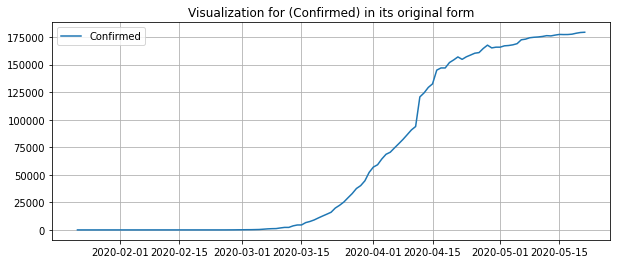

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [10]:
df.tail()

Confirmed
Date                 
2020-05-17     177240
2020-05-18     177554
2020-05-19     178428
2020-05-20     179069
2020-05-21     179306

In [11]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [12]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     177240
2020-05-18     177554
2020-05-19     178428
2020-05-20     179069
2020-05-21     179306

In [13]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [14]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [15]:
#Mean absolute percentage error (MAPE)
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [16]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [17]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [18]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 97399.82992934056, 64053.10743801653)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 97399.82992934056, 64053.10743801653)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 73143.82308199866, 67075.34184823443)
([(0, 0, 0), (0, 0, 0, 365), 't'], 39009.34896010022, 35426.5423870898)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 28694.523941055737, 25153.72146699294)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 49659.232563955426, 32331.54124062295)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 38983.297073629765, 34540.38624293742)
([(0, 0, 1), (0, 0, 0, 365), 't'], 69366.78375468522, 64017.41107228925)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 31431.395334122233, 27661.964123752685)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 27927.677039579456, 17784.838163779386)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 196525.80528877868, 140034.926000596)
([(0, 0, 2), (0, 0, 0, 365), 't'], 47272.882856595366, 42198.32273830845)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 1201991.0669012263, 1061593.194622884)
([(0, 1, 0), (0, 0, 0, 365), '

In [20]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 0, 2), (0, 0, 0, 365), 't'] 2536.991861250632 1090.5473475143488


In [21]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

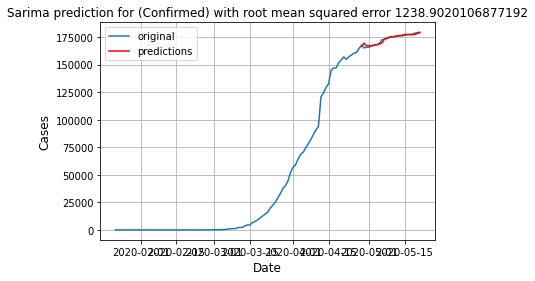

In [22]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cases', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [23]:
mape(test,predictions)

2.9333954621399387

In [24]:
#Recovered Cases in Italy '''

RECOVERED CASES

In [25]:
q=dataframe.query('Country=="France"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      59907
2020-05-18      60416
2020-05-19      61246
2020-05-20      61713
2020-05-21      62216

[121 rows x 1 columns]

**Spilting the dataset**

In [26]:
trainr=dfr[0:97]
testr=dfr[97:]
testr

Recovered
Date                 
2020-04-28      45997
2020-04-29      47338
2020-04-30      48572
2020-05-01      49300
2020-05-02      49751
2020-05-03      49973
2020-05-04      50438
2020-05-05      51803
2020-05-06      53022
2020-05-07      54076
2020-05-08      54770
2020-05-09      54886
2020-05-10      55062
2020-05-11      55569
2020-05-12      56617
2020-05-13      57368
2020-05-14      58300
2020-05-15      59143
2020-05-16      59142
2020-05-17      59907
2020-05-18      60416
2020-05-19      61246
2020-05-20      61713
2020-05-21      62216

In [28]:
# Series to test
column_name = dfr.columns[0]
print("%s cases will be used for the analysis" % column_name)

Recovered cases will be used for the analysis


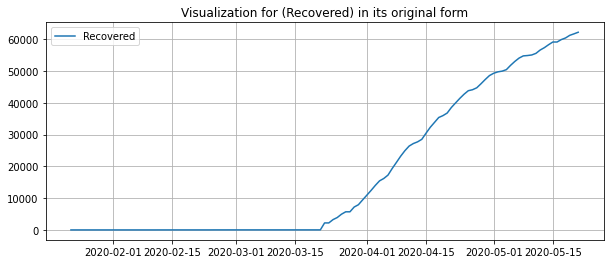

In [29]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [30]:
dfr.tail()

Recovered
Date                 
2020-05-17      59907
2020-05-18      60416
2020-05-19      61246
2020-05-20      61713
2020-05-21      62216

In [31]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [32]:
df_to_test.tail()

Recovered
Date                 
2020-05-17      59907
2020-05-18      60416
2020-05-19      61246
2020-05-20      61713
2020-05-21      62216

In [33]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [34]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [36]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [37]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
           
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [38]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 28586.3833343866, 17803.793388429753)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 28586.3833343866, 17803.793388429753)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 22306.649782871387, 19919.461170685066)
([(0, 0, 0), (0, 0, 0, 365), 't'], 12865.987772727747, 11355.917929470925)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 9565.409210863721, 8378.572321238682)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 14464.451526722429, 9032.129846941076)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 43337.65466378752, 27590.824082471754)
([(0, 0, 1), (0, 0, 0, 365), 't'], 6550.156738952192, 5755.223753508689)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 13477.190689084502, 12072.563741722724)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 7949.290717910723, 4986.9362988482135)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 9478.341690868514, 7331.882185294619)
([(0, 0, 2), (0, 0, 0, 365), 't'], 3778.3686136725264, 3224.5537085482206)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 5487.168894154225, 4639.257417468959)
([(0, 1, 0), (0, 0, 0, 365)

In [39]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 0, 1), (0, 0, 0, 365), 't'] 384.7957348122013 260.42938127408263


In [40]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

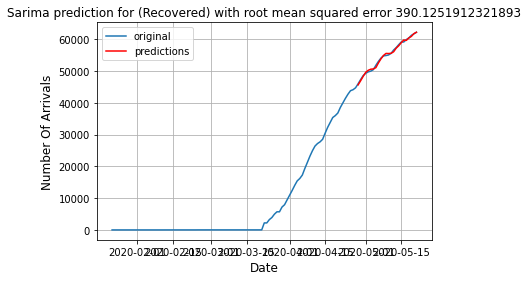

In [41]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [42]:
mape(testr,predictions)

10.139670400162329

In [43]:
# Deaths cases

DEATH CASES

In [44]:
q=dataframe.query('Country=="France"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17   28062
2020-05-18   28193
2020-05-19   27976
2020-05-20   28084
2020-05-21   28167

[121 rows x 1 columns]

In [45]:
# Seriies to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


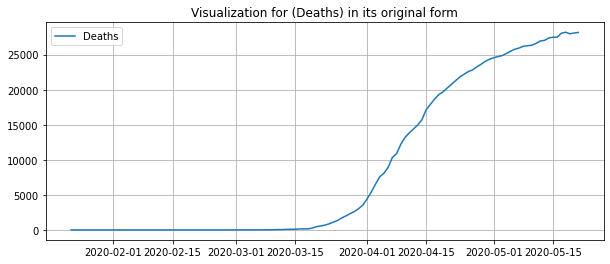

In [46]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [47]:
dfd.tail()

Deaths
Date              
2020-05-17   28062
2020-05-18   28193
2020-05-19   27976
2020-05-20   28084
2020-05-21   28167

In [48]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [49]:
df_to_test.tail()

Deaths
Date              
2020-05-17   28062
2020-05-18   28193
2020-05-19   27976
2020-05-20   28084
2020-05-21   28167

**Spliting the dataset**

In [50]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28   23629
2020-04-29   24056
2020-04-30   24345
2020-05-01   24563
2020-05-02   24729
2020-05-03   24864
2020-05-04   25168
2020-05-05   25498
2020-05-06   25772
2020-05-07   25949
2020-05-08   26192
2020-05-09   26271
2020-05-10   26341
2020-05-11   26604
2020-05-12   26951
2020-05-13   27032
2020-05-14   27381
2020-05-15   27485
2020-05-16   27483
2020-05-17   28062
2020-05-18   28193
2020-05-19   27976
2020-05-20   28084
2020-05-21   28167

In [51]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [52]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [53]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [54]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [55]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 14066.458621736489, 8811.462809917355)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 14066.458621736489, 8811.462809917355)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 10935.342377024348, 9970.429410559389)
([(0, 0, 0), (0, 0, 0, 365), 't'], 6303.563270497399, 5622.1837394245695)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 4739.994680887252, 4145.691475986163)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 7134.031328397934, 4480.808365741151)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 19638.289486383845, 12769.615347118412)
([(0, 0, 1), (0, 0, 0, 365), 't'], 3215.3732415433988, 2871.3303141299616)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 5315.938340383532, 4642.173591601798)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 3823.9226684984287, 2409.141136445067)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 3576.265437355879, 3152.9588138457952)
([(0, 0, 2), (0, 0, 0, 365), 't'], 1916.3111232953138, 1684.836285180652)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 1715.4901297963283, 1391.8248399065124)
([(0, 1, 0), (0, 0, 0, 365),

In [58]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 0, 2), (0, 0, 0, 365), 't'] 166.85564630577574 100.83689759498752


In [59]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

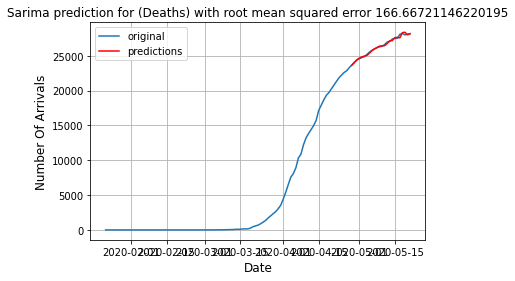

In [60]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [61]:
mape(testd,predictions)

6.175737260004567